<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/gplvm_mocap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Gaussian proceess latent  variable model for motion capture data

http://inverseprobability.com/gpy-gallery/gallery/cmu-mocap-gplvm

Author: Aditya Ravuri 

## Setup

In [1]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-pastel")

In [2]:
%%capture

%pip install -qq --upgrade git+https://github.com/lawrennd/ods
%pip install -qq --upgrade git+https://github.com/SheffieldML/GPy.git
try:
    import GPy, pods
except ModuleNotFoundError:
    %pip install -qq GPy,
    import GPy, pods

In [3]:
import numpy as np

np.random.seed(42)

## CMU Mocap Database



Motion capture data from the CMU motion capture data base (CMU Motion
Capture Lab, 2003).

You can download any subject and motion from the data set. Here we will
download motions `02` and `21` from subject `16`.

In [4]:
subject = "16"
motion = ["02", "21"]
data = pods.datasets.cmu_mocap(subject, motion)

Acquiring resource: cmu_mocap

Details of data: 
CMU Motion Capture data base. Captured by a Vicon motion capture system consisting of 12 infrared MX-40 cameras, each of which is capable of recording at 120 Hz with images of 4 megapixel resolution. Motions are captured in a working volume of approximately 3m x 8m. The capture subject wears 41 markers and a stylish black garment.

Please cite:
Please include this in your acknowledgements: The data used in this project was obtained from mocap.cs.cmu.edu.\nThe database was created with funding from NSF EIA-0196217.

Data will be stored in /root/ods_data_cache/cmu_mocap.

You must also agree to the following license:
From http://mocap.cs.cmu.edu. This data is free for use in research projects. You may include this data in commercially-sold products, but you may not resell this data directly, even in converted form. If you publish results obtained using this data, we would appreciate it if you would send the citation to your published paper

The data dictionary contains the keys ‘Y’ and ‘skel,’ which represent
the data and the skeleton..

In [5]:
data["Y"].shape

(195, 62)

In [6]:
print(data["citation"])

Please include this in your acknowledgements: The data used in this project was obtained from mocap.cs.cmu.edu.\nThe database was created with funding from NSF EIA-0196217.


And extra information about the data is included, as standard, under the
keys `info` and `details`.

In [7]:
print(data["info"])
print(data["details"])

Subject: 16. Training motions: 02, 21. Data is sub-sampled to every 4 frames.
CMU Motion Capture data base. Captured by a Vicon motion capture system consisting of 12 infrared MX-40 cameras, each of which is capable of recording at 120 Hz with images of 4 megapixel resolution. Motions are captured in a working volume of approximately 3m x 8m. The capture subject wears 41 markers and a stylish black garment.


## Fit GP-LVM



The original data has the figure moving across the floor during the
motion capture sequence. We can make the figure walk ‘in place,’ by
setting the x, y, z positions of the root node to zero. This makes it
easier to visualize the result.

In [8]:
# Make figure move in place.
data["Y"][:, 0:3] = 0.0

We can also remove the mean of the data.

In [9]:
Y = data["Y"]

Now we create the GP-LVM model.

In [10]:
model = GPy.models.GPLVM(Y, 2, init="PCA", normalizer=True)

 /usr/local/lib/python3.7/dist-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Now we optimize the model.

In [11]:
model.optimize(optimizer="lbfgs", messages=True, max_f_eval=1e4, max_iters=1e4)

## Plotting the skeleton

In [12]:
%matplotlib inline

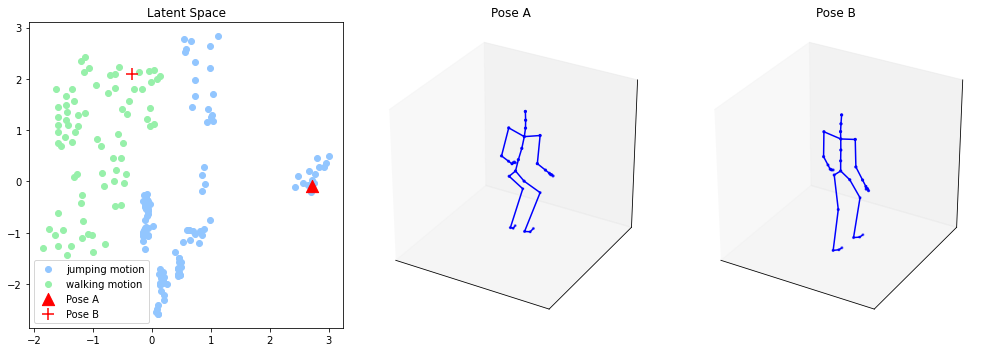

In [23]:
def plot_skeleton(ax, Y_vec):

    Z = data["skel"].to_xyz(Y_vec)
    ax.scatter(Z[:, 0], Z[:, 2], Z[:, 1], marker=".", color="b")

    connect = data["skel"].connection_matrix()  # Get the connectivity matrix.
    I, J = np.nonzero(connect)
    xyz = np.zeros((len(I) * 3, 3))
    idx = 0
    for i, j in zip(I, J):
        xyz[idx] = Z[i, :]
        xyz[idx + 1] = Z[j, :]
        xyz[idx + 2] = [np.nan] * 3
        idx += 3
    line_handle = ax.plot(xyz[:, 0], xyz[:, 2], xyz[:, 1], "-", color="b")
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_zlim(-15, 15)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_zticks([])
    plt.tight_layout()


# fig = plt.figure(figsize=(7,2.5))
fig = plt.figure(figsize=(14, 5))

ax_a = fig.add_subplot(131)
ax_a.set_title("Latent Space")

n = len(Y)
idx_a = 51  # jumping
idx_b = 180  # standing
other_indices = np.arange(n)[~np.isin(range(n), [idx_a, idx_b])]
jump = np.arange(n)[data["lbls"][:, 0] == 1]
walk = np.arange(n)[data["lbls"][:, 0] == 0]

jump = jump[jump != idx_a]
walk = walk[walk != idx_b]

ax_a.scatter(model.X[jump, 0], model.X[jump, 1], label="jumping motion")
ax_a.scatter(model.X[walk, 0], model.X[walk, 1], label="walking motion")
ax_a.scatter(model.X[idx_a, 0], model.X[idx_a, 1], label="Pose A", marker="^", s=150, c="red")
ax_a.scatter(model.X[idx_b, 0], model.X[idx_b, 1], label="Pose B", marker="+", s=150, c="red")
ax_a.legend(loc="lower left")  # , fontsize='x-small')

plt.tight_layout()

ax_b = fig.add_subplot(132, projection="3d")
plot_skeleton(ax_b, Y[idx_a, :])
ax_b.set_title("Pose A")

ax_c = fig.add_subplot(133, projection="3d")
plot_skeleton(ax_c, Y[idx_b, :])
ax_c.set_title("Pose B")

# print(fig)

plt.savefig("gplvm-mocap.pdf")
plt.show()

<Figure size 432x288 with 0 Axes>